In [34]:
import pandas as pd
import scanpy as sc
import sys
import numpy as np
import scipy
import joblib
import matplotlib.pyplot as plt
from utils import *

In [35]:
out_file_path = './'
data_dir = out_file_path + 'data/'
gene_signature_dir = out_file_path + 'gene_signatures/'
out_dir = out_file_path + 'compass_hypergeom_results/'

From DESeq2, look for enrichment of metabolism terms in DE genes

**read gene signatures**

In [36]:
out_filename = gene_signature_dir + 'metabolism_rxn_subsystem.pickle'
subsystem_to_genes = joblib.load(out_filename)
metabolism_sig = {key: [item[0] for item in subsystem_to_genes[key]] for key in subsystem_to_genes}

In [37]:
for k,v in metabolism_sig.items():
    print(f'{k}: {len(v)}')

Fatty acid oxidation: 32
Nucleotide interconversion: 102
Keratan sulfate degradation: 11
Sphingolipid metabolism: 29
Tyrosine metabolism: 34
Keratan sulfate synthesis: 15
Steroid metabolism: 25
Chondroitin synthesis: 30
Tryptophan metabolism: 36
Glycerophospholipid metabolism: 61
Inositol phosphate metabolism: 60
Folate metabolism: 11
Valine, leucine, and isoleucine metabolism: 31
Chondroitin sulfate degradation: 10
Cholesterol metabolism: 22
Arginine and Proline Metabolism: 33
Bile acid synthesis: 9
Fatty acid synthesis: 8
Glycine, serine, alanine and threonine metabolism: 23
Pyrimidine catabolism: 23
Blood group synthesis: 5
Pyruvate metabolism: 32
Aminosugar metabolism: 26
Heparan sulfate degradation: 6
Urea cycle: 17
Purine catabolism: 13
Eicosanoid metabolism: 19
Methionine and cysteine metabolism: 20
Lysine metabolism: 25
Starch and sucrose metabolism: 14
Pentose phosphate pathway: 12
NAD metabolism: 14
Vitamin A metabolism: 15
beta-Alanine metabolism: 21
Triacylglycerol synthesi

In [38]:
print(len(metabolism_sig.keys()))

81


In [39]:
# read in DE genes
compass_data = pd.read_csv(data_dir + 'th_data/GSE162300_DFMO_RNA_est_counts.csv', sep = ',', index_col = 0) # this is library size normalized already
samples = list(set([i[:-9] for i in compass_data.columns]))

In [40]:
n_genes_total = len(compass_data.index)
n_genes_total

20817

In [41]:
# these are for thP vs N

In [42]:
de_genes_th_1 = pd.read_csv(data_dir + 'th_data/deseq_genes_th_uncollapse.csv', index_col = 0)
de_genes_th_2 = pd.read_csv(data_dir + 'th_data/deseq_genes_th_collapse.csv', index_col = 0)

# for DE genes of Th17p vs Th17n

In [43]:
logfc_thresh = 0
p_thresh = 0.05

In [44]:
de_genes_th_1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610007P14RIK,944.099532,-0.145766,0.050880,-2.864867,4.171846e-03,1.344874e-02
0610009B22RIK,86.186921,0.244914,0.142373,1.720221,8.539226e-02,1.719417e-01
0610009L18RIK,3.371014,-0.814473,0.686218,-1.186901,2.352666e-01,3.753754e-01
0610009O20RIK,195.335549,-0.110608,0.093428,-1.183884,2.364589e-01,3.767663e-01
0610010F05RIK,25.537423,-0.075539,0.247169,-0.305619,7.598948e-01,8.430450e-01
...,...,...,...,...,...,...
ZYG11A,0.000000,NaN,NaN,NaN,NaN,NaN
ZYG11B,288.482467,0.080973,0.090098,0.898727,3.687982e-01,5.198402e-01
ZYX,398.640411,-0.455847,0.070043,-6.508119,7.609765e-11,8.329504e-10
ZZEF1,212.350099,0.151869,0.107047,1.418710,1.559836e-01,2.755397e-01


In [45]:
M = n_genes_total
hypergeom_res_th_1 = {k: {} for k in ['pvn', 'nvp']}
for key in ['pvn', 'nvp']:
    df = de_genes_th_1.copy()
    df = df[df['padj'] < p_thresh]
    if key == 'pvn':
        df = df[df['log2FoldChange'] > logfc_thresh]
    else:
        df = df[df['log2FoldChange'] < logfc_thresh]
    print(f'{key}: {len(df)}')
    df['genes'] = df.index.str.upper()
    df_genes = set(df['genes'])
    N = len(df) # length of DE genes
    for k,v in metabolism_sig.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)

        if pct_overlap > 0:
            p_val = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_th_1[key][k] = p_val
        else:
            hypergeom_res_th_1[key][k] = 1

pvn: 2443
nvp: 2476


In [46]:
hypergeom_df_th = pd.DataFrame.from_dict(hypergeom_res_th_1)
hypergeom_df_th['term'] = hypergeom_df_th.index
hypergeom_res_th_1hypergeom_df_th = hypergeom_df_th.melt('term')
hypergeom_df_th['padj_pvn'] = adjust_p_value_fdr(hypergeom_df_th['pvn'])
hypergeom_df_th['padj_nvp'] = adjust_p_value_fdr(hypergeom_df_th['nvp'])
hypergeom_df_th

,pvn,nvp,term,padj_pvn,padj_nvp
Fatty acid oxidation,0.742000,0.538351,Fatty acid oxidation,1.000000,0.889927
Nucleotide interconversion,0.003273,0.326004,Nucleotide interconversion,0.132538,0.800192
Keratan sulfate degradation,0.129888,0.033090,Keratan sulfate degradation,0.584496,0.335037
Sphingolipid metabolism,0.677954,0.122499,Sphingolipid metabolism,1.000000,0.583671
Tyrosine metabolism,0.368829,0.786827,Tyrosine metabolism,0.933599,1.000000
...,...,...,...,...,...
"Transport, lysosomal",0.010499,0.938418,"Transport, lysosomal",0.141740,1.000000
Vitamin B12 metabolism,1.000000,1.000000,Vitamin B12 metabolism,1.000000,1.000000
N-glycan synthesis,0.393088,0.072004,N-glycan synthesis,0.936475,0.530212
D-alanine metabolism,1.000000,1.000000,D-alanine metabolism,1.000000,1.000000


In [47]:
print(f"pvn: {len(hypergeom_df_th[hypergeom_df_th['padj_pvn'] < 0.05])}\nnvp: {len(hypergeom_df_th[hypergeom_df_th['padj_nvp'] < 0.05])}")
      

pvn: 0
nvp: 1


In [48]:
th_results_pvn = hypergeom_df_th[hypergeom_df_th['padj_pvn'] < 0.05].sort_values('padj_pvn')
th_results_pvn

,pvn,nvp,term,padj_pvn,padj_nvp


In [49]:
th_results_nvp = hypergeom_df_th[hypergeom_df_th['padj_nvp'] < 0.05].sort_values('padj_nvp')
th_results_nvp

,pvn,nvp,term,padj_pvn,padj_nvp
Inositol phosphate metabolism,0.847815,0.000454,Inositol phosphate metabolism,1.0,0.036789


In [22]:
# th_results_pvn.to_csv(out_dir + 'hypergeom_th_results_Th17p_v_Th17n_compass.csv')
# th_results_nvp.to_csv(out_dir + 'hypergeom_th_results_Th17n_v_Th17p_compass.csv')

## remove non-overlapping genes

In [50]:
all_genes = list(compass_data.index)
overlapping_terms, n_removed_terms = get_overlapping_met_genes(metabolism_sig, all_genes, verb = True)

Fatty acid oxidation	original: 32 | overlapping: 32 | removed: 0
Nucleotide interconversion	original: 102 | overlapping: 101 | removed: 1
Keratan sulfate degradation	original: 11 | overlapping: 11 | removed: 0
Sphingolipid metabolism	original: 29 | overlapping: 29 | removed: 0
Tyrosine metabolism	original: 34 | overlapping: 33 | removed: 1
Keratan sulfate synthesis	original: 15 | overlapping: 14 | removed: 1
Steroid metabolism	original: 25 | overlapping: 24 | removed: 1
Chondroitin synthesis	original: 30 | overlapping: 30 | removed: 0
Tryptophan metabolism	original: 36 | overlapping: 35 | removed: 1
Glycerophospholipid metabolism	original: 61 | overlapping: 59 | removed: 2
Inositol phosphate metabolism	original: 60 | overlapping: 60 | removed: 0
Folate metabolism	original: 11 | overlapping: 10 | removed: 1
Valine, leucine, and isoleucine metabolism	original: 31 | overlapping: 31 | removed: 0
Chondroitin sulfate degradation	original: 10 | overlapping: 10 | removed: 0
Cholesterol metabol

(array([ 2.,  0.,  0.,  0.,  1.,  1.,  3.,  4.,  8., 62.]),
 array([0.79166667, 0.8125    , 0.83333333, 0.85416667, 0.875     ,
        0.89583333, 0.91666667, 0.9375    , 0.95833333, 0.97916667,
        1.        ]),
 <BarContainer object of 10 artists>)

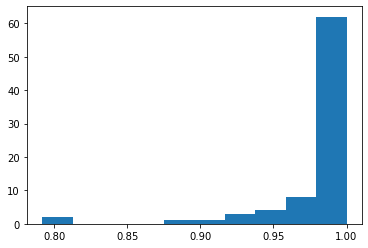

In [51]:
prop_removed = {}
for k,v in n_removed_terms.items():
    prop_removed[k] = (len(metabolism_sig[k]) - v)/len(metabolism_sig[k])
plt.hist(prop_removed.values())

(array([61.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.   , 0.175, 0.35 , 0.525, 0.7  , 0.875, 1.05 , 1.225, 1.4  ,
        1.575, 1.75 , 1.925, 2.1  , 2.275, 2.45 , 2.625, 2.8  , 2.975,
        3.15 , 3.325, 3.5  , 3.675, 3.85 , 4.025, 4.2  , 4.375, 4.55 ,
        4.725, 4.9  , 5.075, 5.25 , 5.425, 5.6  , 5.775, 5.95 , 6.125,
        6.3  , 6.475, 6.65 , 6.825, 7.   ]),
 <BarContainer object of 40 artists>)

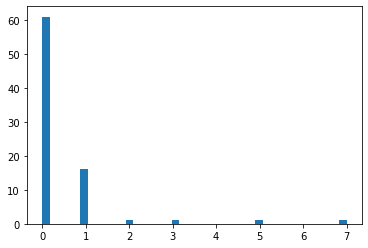

In [52]:
plt.hist(n_removed_terms.values(), bins = 40)

In [53]:
# remove keys without genes
for k in [k for k,v in overlapping_terms.items() if len(v) == 0]:
    print(k)
    overlapping_terms.pop(k)

In [66]:
M = n_genes_total
hypergeom_res_th_overlap = {k: {} for k in ['pvn', 'nvp']}
for key in ['pvn', 'nvp']:
    df = de_genes_th_1.copy()
    df = df[df['padj'] < p_thresh]
    if key == 'pvn':
        df = df[df['log2FoldChange'] > logfc_thresh]
    else:
        df = df[df['log2FoldChange'] < logfc_thresh]
    print(f'{key}: {len(df)}')
    df['genes'] = df.index.str.upper()
    df_genes = set(df['genes'])
    N = len(df) # length of DE genes
    for k,v in overlapping_terms.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)

        if pct_overlap > 0:
            p_val = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_th_overlap[key][k] = p_val
        else:
            hypergeom_res_th_overlap[key][k] = 1

pvn: 2443
nvp: 2476


In [77]:
hypergeom_df_th_overlap = pd.DataFrame.from_dict(hypergeom_res_th_overlap)
hypergeom_df_th_overlap['term'] = hypergeom_df_th_overlap.index
hypergeom_df_th_overlap['padj_pvn'] = adjust_p_value_bh(hypergeom_df_th_overlap['pvn'].values)
hypergeom_df_th_overlap['padj_nvp'] = adjust_p_value_bh(hypergeom_df_th_overlap['nvp'].values)
hypergeom_df_th_overlap['q_pvn'] = adjust_p_value_qval(hypergeom_df_th_overlap['pvn'].values,pi_0=None)
hypergeom_df_th_overlap['q_nvp'] = adjust_p_value_qval(hypergeom_df_th_overlap['nvp'].values,pi_0=None)
hypergeom_df_th_overlap

,pvn,nvp,term,padj_pvn,padj_nvp,q_pvn,q_nvp
Fatty acid oxidation,0.742000,0.538351,Fatty acid oxidation,1.000000,0.886778,1.000000,0.886778
Nucleotide interconversion,0.002879,0.312586,Nucleotide interconversion,0.092490,0.748814,0.092490,0.748814
Keratan sulfate degradation,0.129888,0.033090,Keratan sulfate degradation,0.584496,0.335037,0.584496,0.335037
Sphingolipid metabolism,0.677954,0.122499,Sphingolipid metabolism,1.000000,0.551245,1.000000,0.551245
Tyrosine metabolism,0.344419,0.769291,Tyrosine metabolism,0.899933,1.000000,0.899933,1.000000
...,...,...,...,...,...,...,...
"Transport, lysosomal",0.010499,0.938418,"Transport, lysosomal",0.141740,1.000000,0.141740,1.000000
Vitamin B12 metabolism,1.000000,1.000000,Vitamin B12 metabolism,1.000000,1.000000,1.000000,1.000000
N-glycan synthesis,0.393088,0.072004,N-glycan synthesis,0.909718,0.486028,0.909718,0.486028
D-alanine metabolism,1.000000,1.000000,D-alanine metabolism,1.000000,1.000000,1.000000,1.000000


In [78]:
print(f"pvn: {len(hypergeom_df_th_overlap[hypergeom_df_th_overlap['q_pvn'] < 0.05])}\nnvp: {len(hypergeom_df_th_overlap[hypergeom_df_th_overlap['q_nvp'] < 0.05])}")

pvn: 0
nvp: 1


In [79]:
print(f"pvn: {len(hypergeom_df_th_overlap[hypergeom_df_th_overlap['padj_pvn'] < 0.05])}\nnvp: {len(hypergeom_df_th_overlap[hypergeom_df_th_overlap['padj_nvp'] < 0.05])}")

pvn: 0
nvp: 1


In [144]:
th_results_overlap_pvn = hypergeom_df_th_overlap[hypergeom_df_th_overlap['q_pvn'] < 0.05].sort_values('q_pvn')
th_results_overlap_nvp = hypergeom_df_th_overlap[hypergeom_df_th_overlap['q_nvp'] < 0.05].sort_values('q_nvp')

print('pvn')
display(th_results_overlap_pvn)
print('nvp')
display(th_results_overlap_nvp)

pvn


,pvn,nvp,term,padj_pvn,padj_nvp,q_pvn,q_nvp


nvp


,pvn,nvp,term,padj_pvn,padj_nvp,q_pvn,q_nvp
Inositol phosphate metabolism,0.847815,0.000454,Inositol phosphate metabolism,1.0,0.036789,1.0,0.036789


In [146]:
print('pvn')
display(hypergeom_df_th_overlap[hypergeom_df_th_overlap['q_pvn'] < .2].sort_values('q_pvn'))
print('nvp')
display(hypergeom_df_th_overlap[hypergeom_df_th_overlap['q_nvp'] < .2].sort_values('q_nvp'))

pvn


,pvn,nvp,term,padj_pvn,padj_nvp,q_pvn,q_nvp
Nucleotide interconversion,0.002879,0.312586,Nucleotide interconversion,0.092490,0.748814,0.092490,0.748814
"Valine, leucine, and isoleucine metabolism",0.002096,0.067684,"Valine, leucine, and isoleucine metabolism",0.092490,0.486028,0.092490,0.486028
"Glycine, serine, alanine and threonine metabolism",0.003426,0.777104,"Glycine, serine, alanine and threonine metabolism",0.092490,1.000000,0.092490,1.000000
Purine synthesis,0.005890,1.000000,Purine synthesis,0.119279,1.000000,0.119279,1.000000
Pentose phosphate pathway,0.008620,0.781288,Pentose phosphate pathway,0.139650,1.000000,0.139650,1.000000
"Transport, lysosomal",0.010499,0.938418,"Transport, lysosomal",0.141740,1.000000,0.141740,1.000000


nvp


,pvn,nvp,term,padj_pvn,padj_nvp,q_pvn,q_nvp
Inositol phosphate metabolism,0.847815,0.000454,Inositol phosphate metabolism,1.000000,0.036789,1.000000,0.036789
Cholesterol metabolism,0.724483,0.001923,Cholesterol metabolism,1.000000,0.066273,1.000000,0.066273
Heme synthesis,0.527206,0.002455,Heme synthesis,0.970539,0.066273,0.970539,0.066273
Keratan sulfate synthesis,0.221345,0.003612,Keratan sulfate synthesis,0.666932,0.073153,0.666932,0.073153
Aminosugar metabolism,0.364694,0.008583,Aminosugar metabolism,0.909718,0.139037,0.909718,0.139037


In [82]:
th_results_overlap_pvn.to_csv(out_dir + 'hypergeom_th_results_overlap_Th17p_v_Th17n_compass_q.csv')
th_results_overlap_nvp.to_csv(out_dir + 'hypergeom_th_results_overlap_Th17n_v_Th17p_compass_q.csv')

# more stringent filtering of genes

filter to at least 5 genes in signature & 70% of genes are retained

In [96]:
all_genes = list(compass_data.index)
overlapping_terms, n_removed_terms = get_overlapping_met_genes(metabolism_sig, all_genes, verb = False)

(array([21.,  9.,  6., 16.,  3.,  5.,  7.,  1.,  3.,  5.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  1.        ,   4.33333333,   7.66666667,  11.        ,
         14.33333333,  17.66666667,  21.        ,  24.33333333,
         27.66666667,  31.        ,  34.33333333,  37.66666667,
         41.        ,  44.33333333,  47.66666667,  51.        ,
         54.33333333,  57.66666667,  61.        ,  64.33333333,
         67.66666667,  71.        ,  74.33333333,  77.66666667,
         81.        ,  84.33333333,  87.66666667,  91.        ,
         94.33333333,  97.66666667, 101.        ]),
 <BarContainer object of 30 artists>)

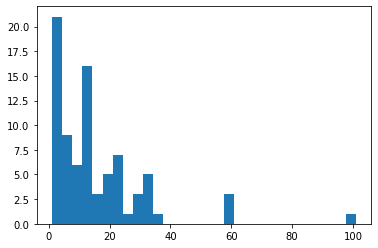

In [112]:
plt.hist([len(v) for v in overlapping_terms.values()], bins = 30)

(array([ 2.,  0.,  0.,  0.,  1.,  1.,  3.,  4.,  8., 62.]),
 array([0.79166667, 0.8125    , 0.83333333, 0.85416667, 0.875     ,
        0.89583333, 0.91666667, 0.9375    , 0.95833333, 0.97916667,
        1.        ]),
 <BarContainer object of 10 artists>)

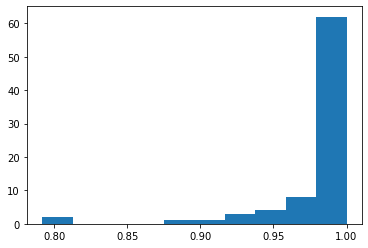

In [106]:
prop_removed = {}
for k,v in n_removed_terms.items():
    prop_removed[k] = (len(metabolism_sig[k]) - v)/len(metabolism_sig[k])
plt.hist(prop_removed.values())

In [109]:
# remove keys without genes
min_length = 5
min_prop = .7
overlapping_terms_filter = {}
for k,v in overlapping_terms.items():
    if (len(v) >= min_length) & (prop_removed[k] > min_prop):
        overlapping_terms_filter[k] = v
    else:
        print('popped ' + k)

popped Biotin metabolism
popped ROS detoxification
popped Purine synthesis
popped C5-branched dibasic acid metabolism
popped Nucleotide salvage pathway
popped Cytochrome metabolism
popped Vitamin B6 metabolism
popped Taurine and hypotaurine metabolism
popped Transport, mitochondrial
popped Nucleotide sugar metabolism
popped Alkaloid synthesis
popped CoA synthesis
popped Stilbene, coumarine and lignin synthesis
popped O-glycan synthesis
popped Ubiquinone synthesis
popped CoA catabolism
popped Citric acid cycle
popped Vitamin B12 metabolism
popped N-glycan synthesis
popped D-alanine metabolism
popped Thiamine metabolism


In [113]:
print(f'len original: {len(overlapping_terms.items())}')
print(f'len filtered: {len(overlapping_terms_filter.items())}')

len original: 81
len filtered: 60


In [116]:
M = n_genes_total
hypergeom_res_th_overlap_2 = {k: {} for k in ['pvn', 'nvp']}
for key in ['pvn', 'nvp']:
    df = de_genes_th_1.copy()
    df = df[df['padj'] < p_thresh]
    if key == 'pvn':
        df = df[df['log2FoldChange'] > logfc_thresh]
    else:
        df = df[df['log2FoldChange'] < logfc_thresh]
    print(f'{key}: {len(df)}') # the number of DE genes for each condition
    df['genes'] = df.index.str.upper()
    df_genes = set(df['genes'])
    N = len(df) # length of DE genes
    for k,v in overlapping_terms_filter.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)

        if pct_overlap > 0:
            p_val = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_th_overlap_2[key][k] = p_val
        else:
            hypergeom_res_th_overlap_2[key][k] = 1

pvn: 2443
nvp: 2476


In [117]:
hypergeom_df_th_overlap_2

,pvn,nvp,term,padj_pvn,padj_nvp,q_pvn,q_nvp
Fatty acid oxidation,0.457471,0.819016,Fatty acid oxidation,1.000000,1.000000,1.000000,1.000000
Nucleotide interconversion,0.354671,0.271716,Nucleotide interconversion,1.000000,0.645890,1.000000,0.645890
Keratan sulfate degradation,1.000000,0.108776,Keratan sulfate degradation,1.000000,0.489491,1.000000,0.489491
Sphingolipid metabolism,1.000000,0.061351,Sphingolipid metabolism,1.000000,0.489491,1.000000,0.489491
Tyrosine metabolism,0.071224,0.517530,Tyrosine metabolism,0.685864,0.998094,0.685864,0.998094
...,...,...,...,...,...,...,...
"Transport, lysosomal",0.284392,0.691146,"Transport, lysosomal",1.000000,1.000000,1.000000,1.000000
Vitamin B12 metabolism,1.000000,1.000000,Vitamin B12 metabolism,1.000000,1.000000,1.000000,1.000000
N-glycan synthesis,0.178258,0.192265,N-glycan synthesis,0.962591,0.576794,0.962591,0.576794
D-alanine metabolism,1.000000,1.000000,D-alanine metabolism,1.000000,1.000000,1.000000,1.000000


In [118]:
hypergeom_df_th_overlap_2 = pd.DataFrame.from_dict(hypergeom_res_th_overlap_2)
hypergeom_df_th_overlap_2['term'] = hypergeom_df_th_overlap_2.index
hypergeom_df_th_overlap_2['padj_pvn'] = adjust_p_value_bh(hypergeom_df_th_overlap_2['pvn'].values)
hypergeom_df_th_overlap_2['padj_nvp'] = adjust_p_value_bh(hypergeom_df_th_overlap_2['nvp'].values)
hypergeom_df_th_overlap_2['q_pvn'] = adjust_p_value_qval(hypergeom_df_th_overlap_2['pvn'].values,pi_0=None)
hypergeom_df_th_overlap_2['q_nvp'] = adjust_p_value_qval(hypergeom_df_th_overlap_2['nvp'].values,pi_0=None)
hypergeom_df_th_overlap_2

,pvn,nvp,term,padj_pvn,padj_nvp,q_pvn,q_nvp
Fatty acid oxidation,0.742000,0.538351,Fatty acid oxidation,0.967826,0.781991,0.967826,0.710901
Nucleotide interconversion,0.002879,0.312586,Nucleotide interconversion,0.068511,0.669827,0.068511,0.608934
Keratan sulfate degradation,0.129888,0.033090,Keratan sulfate degradation,0.519552,0.248176,0.519552,0.225614
Sphingolipid metabolism,0.677954,0.122499,Sphingolipid metabolism,0.962115,0.489996,0.962115,0.445451
Tyrosine metabolism,0.344419,0.769291,Tyrosine metabolism,0.819400,0.901486,0.819400,0.819533
Keratan sulfate synthesis,0.221345,0.003612,Keratan sulfate synthesis,0.635174,0.054187,0.635174,0.049261
Steroid metabolism,0.790674,0.952210,Steroid metabolism,0.982971,1.000000,0.982971,0.909091
Chondroitin synthesis,0.882266,0.138593,Chondroitin synthesis,1.000000,0.490505,1.000000,0.445914
Tryptophan metabolism,0.222311,0.114729,Tryptophan metabolism,0.635174,0.489996,0.635174,0.445451
Glycerophospholipid metabolism,0.547833,0.157807,Glycerophospholipid metabolism,0.865000,0.490505,0.865000,0.445914


In [119]:
print(f"pvn: {len(hypergeom_df_th_overlap_2[hypergeom_df_th_overlap_2['q_pvn'] < 0.05])}\nnvp: {len(hypergeom_df_th_overlap_2[hypergeom_df_th_overlap_2['q_nvp'] < 0.05])}")

pvn: 0
nvp: 4


In [120]:
print(f"pvn: {len(hypergeom_df_th_overlap_2[hypergeom_df_th_overlap_2['padj_pvn'] < 0.05])}\nnvp: {len(hypergeom_df_th_overlap_2[hypergeom_df_th_overlap_2['padj_nvp'] < 0.05])}")

pvn: 0
nvp: 3


In [121]:
th_results_overlap_pvn_2 = hypergeom_df_th_overlap_2[hypergeom_df_th_overlap_2['q_pvn'] < 0.05].sort_values('q_pvn')
th_results_overlap_pvn_2

,pvn,nvp,term,padj_pvn,padj_nvp,q_pvn,q_nvp


In [122]:
th_results_overlap_nvp_2 = hypergeom_df_th_overlap_2[hypergeom_df_th_overlap_2['q_nvp'] < 0.05].sort_values('q_nvp')
th_results_overlap_nvp_2

,pvn,nvp,term,padj_pvn,padj_nvp,q_pvn,q_nvp
Inositol phosphate metabolism,0.847815,0.000454,Inositol phosphate metabolism,1.000000,0.027251,1.000000,0.024774
Cholesterol metabolism,0.724483,0.001923,Cholesterol metabolism,0.965978,0.049091,0.965978,0.044628
Heme synthesis,0.527206,0.002455,Heme synthesis,0.854929,0.049091,0.854929,0.044628
Keratan sulfate synthesis,0.221345,0.003612,Keratan sulfate synthesis,0.635174,0.054187,0.635174,0.049261


In [ ]:
# reformat results

In [130]:
cols = ['pvn', 'term', 'padj_pvn', 'q_pvn']
res_overlap_2_pvn = hypergeom_df_th_overlap_2[cols].reset_index(drop = True).copy()
res_overlap_2_pvn.columns = ['p', 'term', 'padj', 'q']
res_overlap_2_pvn = res_overlap_2_pvn[['term', 'p', 'padj', 'q']]
res_overlap_2_pvn

,term,p,padj,q
0,Fatty acid oxidation,0.742000,0.967826,0.967826
1,Nucleotide interconversion,0.002879,0.068511,0.068511
2,Keratan sulfate degradation,0.129888,0.519552,0.519552
3,Sphingolipid metabolism,0.677954,0.962115,0.962115
4,Tyrosine metabolism,0.344419,0.819400,0.819400
5,Keratan sulfate synthesis,0.221345,0.635174,0.635174
6,Steroid metabolism,0.790674,0.982971,0.982971
7,Chondroitin synthesis,0.882266,1.000000,1.000000
8,Tryptophan metabolism,0.222311,0.635174,0.635174
9,Glycerophospholipid metabolism,0.547833,0.865000,0.865000


In [131]:
cols = ['nvp', 'term', 'padj_nvp', 'q_nvp']
res_overlap_2_nvp = hypergeom_df_th_overlap_2[cols].reset_index(drop = True).copy()
res_overlap_2_nvp.columns = ['p', 'term', 'padj', 'q']
res_overlap_2_nvp = res_overlap_2_nvp[['term', 'p', 'padj', 'q']]
res_overlap_2_nvp

,term,p,padj,q
0,Fatty acid oxidation,0.538351,0.781991,0.710901
1,Nucleotide interconversion,0.312586,0.669827,0.608934
2,Keratan sulfate degradation,0.033090,0.248176,0.225614
3,Sphingolipid metabolism,0.122499,0.489996,0.445451
4,Tyrosine metabolism,0.769291,0.901486,0.819533
5,Keratan sulfate synthesis,0.003612,0.054187,0.049261
6,Steroid metabolism,0.952210,1.000000,0.909091
7,Chondroitin synthesis,0.138593,0.490505,0.445914
8,Tryptophan metabolism,0.114729,0.489996,0.445451
9,Glycerophospholipid metabolism,0.157807,0.490505,0.445914


In [133]:
# res_overlap_2_nvp.to_csv(out_dir + 'results_Th17n_v_p_compass_rxns_q.csv')
# res_overlap_2_pvn.to_csv(out_dir + 'results_Th17p_v_n_compass_rxns_q.csv')

In [148]:
print('pvn')
display(res_overlap_2_pvn[res_overlap_2_pvn['q'] < .05])
print('nvp')
display(res_overlap_2_nvp[res_overlap_2_nvp['q'] < .05])

pvn


,term,p,padj,q


nvp


,term,p,padj,q
5,Keratan sulfate synthesis,0.003612,0.054187,0.049261
10,Inositol phosphate metabolism,0.000454,0.027251,0.024774
14,Cholesterol metabolism,0.001923,0.049091,0.044628
47,Heme synthesis,0.002455,0.049091,0.044628


In [149]:
print('pvn')
display(res_overlap_2_pvn[res_overlap_2_pvn['q'] < .1])
print('nvp')
display(res_overlap_2_nvp[res_overlap_2_nvp['q'] < .1])

pvn


,term,p,padj,q
1,Nucleotide interconversion,0.002879,0.068511,0.068511
12,"Valine, leucine, and isoleucine metabolism",0.002096,0.068511,0.068511
18,"Glycine, serine, alanine and threonine metabolism",0.003426,0.068511,0.068511


nvp


,term,p,padj,q
5,Keratan sulfate synthesis,0.003612,0.054187,0.049261
10,Inositol phosphate metabolism,0.000454,0.027251,0.024774
14,Cholesterol metabolism,0.001923,0.049091,0.044628
22,Aminosugar metabolism,0.008583,0.102991,0.093628
47,Heme synthesis,0.002455,0.049091,0.044628
